# EX4 멋진 작사가 만들기
## 데이터 읽어오기

In [1]:
import glob
import os, re 
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?"]


## 데이터 정제
### 문장 전처리

In [2]:
#문장 전처리하는 함수 정의
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 소문자로 변환 + 양쪽 공백 제거
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 특수문자 양쪽에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence) # 여러 공백은 공백 하나로 변환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # a-zA-Z?.!,¿를 제외한 문자 공백으로 변환
    sentence = sentence.strip() # 양쪽 공백 제거
    sentence = '<start> ' + sentence + ' <end>' # <start> <end> 토큰 추가
    return sentence


In [3]:
corpus = []

for sentence in raw_corpus:
    # 빈 문장은 스킵
    if len(sentence) == 0: continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 문장 확인
print(len(corpus))
corpus[:10]

175749


['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>',
 '<start> it goes like this <end>',
 '<start> the fourth , the fifth <end>',
 '<start> the minor fall , the major lift <end>',
 '<start> the baffled king composing hallelujah hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah your faith was strong but you needed proof <end>']

### 문장 토큰화

In [4]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, # 단어 수 12000 개로 설정
        filters=' ',
        oov_token="<unk>"
    )
    # corpus의 문장들에 맞추어 단어장 완성
    tokenizer.fit_on_texts(corpus)
    
    # tokenizer를 이용하여 corpus를 tensor로 변환
    tensor = tokenizer.texts_to_sequences(corpus)   
    
    # 시퀀스의 토큰의 수가 15를 넘어가는 경우 삭제
    tensor = [sequence for sequence in tensor if len(sequence)<16]
    
    # 패딩으로 시퀀스 길이 통일
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   50    5 ...    0    0    0]
 [   2   17 2639 ...    0    0    0]
 [   2   36    7 ...   43    3    0]
 ...
 [   2    5  107 ...    0    0    0]
 [   2  261  200 ...   12    3    0]
 [   2    7   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fd05fb8c220>


In [5]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2   50    5   91  297   65   57    9  969 6042    3    0    0    0]
[  50    5   91  297   65   57    9  969 6042    3    0    0    0    0]


### 훈련 데이터와 평가 데이터 분리

In [6]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=42)

In [7]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (124810, 14)
Target Train: (124810, 14)


## 인공지능 만들기
### 모델 생성

In [8]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 512
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

### 모델 학습

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

optimizer = tf.keras.optimizers.Adam()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_weights_only=True, save_best_only=True)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
history = model.fit(enc_train, dec_train, batch_size=256 , epochs=10, callbacks=[es, mc], validation_data = (enc_val, dec_val))

Epoch 1/10
488/488 [==============================] - 269s 509ms/step - loss: 3.2806 - val_loss: 2.9121

Epoch 00001: val_loss improved from inf to 2.91211, saving model to best_model.h5
Epoch 2/10
488/488 [==============================] - 258s 528ms/step - loss: 2.7321 - val_loss: 2.6531

Epoch 00002: val_loss improved from 2.91211 to 2.65308, saving model to best_model.h5
Epoch 3/10
488/488 [==============================] - 258s 529ms/step - loss: 2.4131 - val_loss: 2.4708

Epoch 00003: val_loss improved from 2.65308 to 2.47081, saving model to best_model.h5
Epoch 4/10
488/488 [==============================] - 258s 529ms/step - loss: 2.0990 - val_loss: 2.3308

Epoch 00004: val_loss improved from 2.47081 to 2.33078, saving model to best_model.h5
Epoch 5/10
488/488 [==============================] - 259s 530ms/step - loss: 1.8018 - val_loss: 2.2324

Epoch 00005: val_loss improved from 2.33078 to 2.23236, saving model to best_model.h5
Epoch 6/10
488/488 [=============================

최소 validation loss가 2.13851인 모델을 저장하였다. ('best_model.h5')

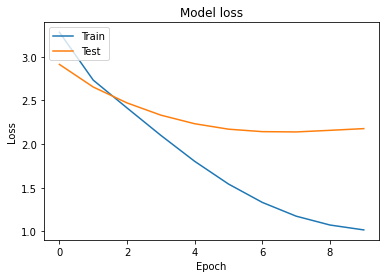

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 가사 생성
### 가사 생성 함수 정의

In [14]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

### 가사 생성 확인

In [22]:
# validation loss가 가장 적은 모델의 weights 불러오기
# 성능이 제일 좋은 버전의 모델을 사용하는 것이다
model.load_weights('best_model.h5')

In [21]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i m not gonna crack <end> '

In [23]:
generate_text(model, tokenizer, init_sentence="<start> i like", max_len=20)

'<start> i like it when i see you do it <end> '

In [24]:
generate_text(model, tokenizer, init_sentence="<start> i", max_len=20)

'<start> i m a bad bitch , you ain t used to that <end> '

In [25]:
generate_text(model, tokenizer, init_sentence="<start> you", max_len=20)

'<start> you know i m bad , i m bad you know it <end> '

In [26]:
generate_text(model, tokenizer, init_sentence="<start> he", max_len=20)

'<start> he s a balla , he s a balla <end> '

In [27]:
generate_text(model, tokenizer, init_sentence="<start> hey", max_len=20)

'<start> hey , hey , hey , hey , hey , hey , hey <end> '

In [29]:
generate_text(model, tokenizer, init_sentence="<start> hey boy", max_len=20)

'<start> hey boy , i wanna be with you <end> '

In [30]:
generate_text(model, tokenizer, init_sentence="<start> love", max_len=20)

'<start> love me all night long <end> '

In [31]:
generate_text(model, tokenizer, init_sentence="<start> love is", max_len=20)

'<start> love is a losing game it s okay in the day <end> '